<a href="https://colab.research.google.com/github/sm354/Deep-Learning-Assignment-1/blob/main/COL870_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.1 ResNet Model 
Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun Deep Residual Learning for Image Recognition. arXiv:1512.03385

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
class Block(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # CHANGE THIS TO ZERO PADDING RESIDUAL CONNECTION
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, num_blocks, stride=1)
        self.layer2 = self._make_layer(32, num_blocks, stride=2)
        self.layer3 = self._make_layer(64, num_blocks, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNetModel(n,r): #6n+2 layers, r number of classes
    return ResNet(n, r)

In [ ]:
net=ResNetModel(3,10)

In [ ]:
y=net(torch.randn(1, 3, 32, 32))
y.size()

torch.Size([1, 10])

In [ ]:
summary(net, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
             Block-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
            Block-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

# 1.1 Cifar10 Dataset

In [1]:
import torch
import torchvision

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False, download=True)


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [3]:
import PIL.Image as Image
import os
import os.path
import numpy as np
import pickle
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import torchvision.transforms as transforms


class CIFAR10(VisionDataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names',
        'md5': '5ff9c542aee3614f3951f8cda6e48888',
    }

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, size=8):

        super(CIFAR10, self).__init__(root, transform=transform, target_transform=target_transform)

        self.train = train  # training set or test set
        self.size = size # size(8,16,32) of images (8,8), (16,16) or (32,32)

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC
        
        string_train = 'train' if train==True else 'test'
        np.save('%s_x.npy'%string_train,self.data)
        np.save('%s_y.npy'%string_train,self.targets)

        self._load_meta()

    def _load_meta(self):
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        if not check_integrity(path, self.meta['md5']):
            raise RuntimeError('Dataset metadata file not found or corrupted.' +
                               ' You can use download=True to download it')
        with open(path, 'rb') as infile:
            data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.train == True: # Apply train transform
            t1 = transforms.Compose(
                [transforms.RandomCrop(32, padding=4), 
                transforms.RandomHorizontalFlip()])
            img = t1(img)
        img = img.resize((self.size,self.size))

        t2 = transforms.Compose(
            [transforms.ToTensor(), 
            transforms.Normalize((0.4914, 0.4822, 0.4465), 
            (0.2023, 0.1994, 0.2010))])
        img = t2(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self):
        return len(self.data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.tgz_md5)

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")

In [48]:
CIFAR10(root='./CIFAR10', train=True, download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CIFAR10
    Split: Train

In [49]:
CIFAR10(root='./CIFAR10', train=False, download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CIFAR10
    Split: Test

In [50]:
test_x=np.load('test_x.npy')
test_x.shape

(10000, 32, 32, 3)

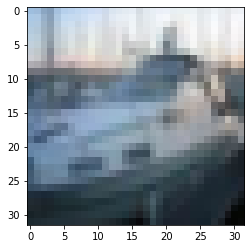

In [51]:
import matplotlib.pyplot as plt
plt.imshow(test_x[2]/255.)
plt.show()

In [52]:
test_y=np.load('test_y.npy')
print(test_y[2])

8


In [53]:
# do train-val split in complete train set (50k images)
train_x=np.load('train_x.npy')
train_y=np.load('train_y.npy')

In [54]:
train_x=train_x.reshape((50000,-1))
train_y=train_y.reshape((-1,1))
print(train_x.shape,train_y.shape)
train_data=np.hstack((train_x,train_y))
print(train_data.shape)

(50000, 3072) (50000, 1)
(50000, 3073)


In [55]:
np.random.shuffle(train_data)

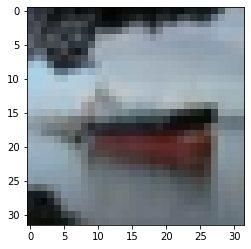

In [58]:
plt.imshow(train_data[2,0:-1].reshape((32,32,3))/255.)
plt.show()

In [59]:
print(train_data[2,-1])

8


In [60]:
train_x=train_data[0:40000,0:-1].reshape((-1,32,32,3))
train_y=train_data[0:40000,-1]

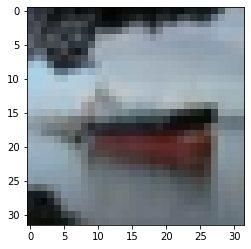

8

In [63]:
plt.imshow(train_x[2]/255.)
plt.show()
train_y[2]

In [64]:
np.save('./CIFAR10/train_x.npy',train_x.astype(np.uint8))
np.save('./CIFAR10/train_y.npy',train_y)

In [66]:
val_x=train_data[40000:,0:-1].reshape((-1,32,32,3)).astype(np.uint8)
val_y=train_data[40000:,-1]
np.save('./CIFAR10/val_x.npy',val_x)
np.save('./CIFAR10/val_y.npy',val_y)